## Tutorial: Deep approximation of retinal traits (DART)

**Author**: Justin Engelmann (firstname [dot] lastname [at] ed [dot] ac [dot] uk)

**Paper**: Robust and efficient computation of retinal fractal dimension through deep approximation

**Preprint**: https://arxiv.org/abs/2207.05757 (to appear in the Proceedings of the 9th MICCAI Workshop on Ophthalmic Medical Image Analysis at MICCAI 2022)

In brief, DART is a method to compute retinal traits in a very efficient way that is robust to common image quality issues. My hope is that this will enable other researchers to discard less data than before.

Currently, we support retinal Fractal Dimension FD as calculated by VAMPIRE (an awesome tool, see: https://vampire.computing.dundee.ac.uk/index.html) with the multi-fractal method. FD is a measure of how complex/branching the retinal vasculature is. This in turn might be a proxy for how healthy the vasculature in the retina is. And this, in turn, could give us some information about someone's general health. 

For an example of this, check out awesome work by Ana Villaplana-Velasco here: https://www.medrxiv.org/content/10.1101/2021.12.16.21267446v1 

I used the VAMPIRE FD values that Ana calculated on the best (in terms of image quality) 60% of the images in UK Biobank for this project. Unfortunately, Ana had to discard about 40% of the data due to quality issues. My hope is that DART will (once I've further validated the method) allow researchers to discard much less than this. Imagine if we discared only 10% instead: Then, we'd go from 60% to 90% of the data, a 50% increase (!!). This is my long term vision.

Please have a look at the pre-print and feel free to contact me with any questions/comments/suggestions/criticisims/objections, etc. Cheers!

### Loading the DART inference pipeline

We make the pre-trained model available, alongside some code that hopefully is very convenient to use. 
As you see below, you can load:
- the Pytorch model itself (load_model()),
- or a dictionary of (get_model_and_processing()):
    - model,
    - preprocessing for the image, 
    - post-processing to scale FD from the normalized values used in training back to the original range,
    - and a config dict
- or a DART inference pipeline (get_inference_pipeline()).

The latter glues everything together and allows us to go directly from image to FD estimate, which should be the most convenient option. Let's load it.

In [1]:
from dart import get_inference_pipeline, get_model_and_processing, load_model

model_pipeline = get_inference_pipeline(model_name='resnet18', loading_verbose=True)

INFO:dart.helpers:Model resnet18 output matches expect value (mean diff: 0.0).
Expected output: tensor([-1.3943])
Actual output: tensor([-1.3943])
Diff: [0.]


Oh, this scary looking red output is a built-in check using an input of all zeros to check if the model has been loaded correctly. It would complain a bit if something seems a little bit off, and outright refuse to work if it was completelty wrong. Here, it is just telling us that everything looks great! (It's done on the CPU; on the GPU, there would be differences in the order of 1e-7 due to cuda non-determinism.)

We can also look at the model pipeline:

In [2]:
model_pipeline

DARTInferencePipeline(model=FD_resnet18, retinal traits=['FractalDimension_VAMPIRE_UKBioBank'])
--- Preprocessing:
	DARTPreprocessingWrapper(transforms_backend=albumentations,resolution=(224, 224), resize=True, norm_mean_stds=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))
--- Model:
	TimmRegressionModel(model_name=resnet18, num_outputs=1, input_size=(224, 224), num_channels=3,
	use_custom_head=True, custom_head_kwargs={'pool_type': 'avg', 'hidden_layer_sizes': (128,), 'hidden_act': 'gelu', 'output_act': 'none', 'input_drop_rate': 0.0, 'hidden_drop_rate': 0.0, 'norm': 'layer', 'in_channels': 512, 'input_size': torch.Size([7, 7])})
	(basemodel): ResNet (11.0000M parameters)
	(head): CustomHead(in_channels=512, num_outputs=1, input_size=torch.Size([7, 7]), pool_type=avg, output_act=Identity(),hidden_layer_sizes=(128,), hidden_act=gelu, input_drop_rate=0.0, hidden_drop_rate=0.0, norm=layer) (0.0000M parameters)
	Total param count: 11.0000M parameters
--- Postprocessing:
	DARTInvMeanStdSca

It tells us everything we need to know about the pipeline and then some. Most information won't be too relevant to most users, but the first line notes the model and which retinal trait the model outputs. Currently, we only support VAMPIRE FD trained on UK Biobank.

### Applying DART to an image

Let's download an example image. In the paper, we used UK Biobank, but I cannot share these images, unfortunately. So, we're using an image from the DRIVE dataset as an example.

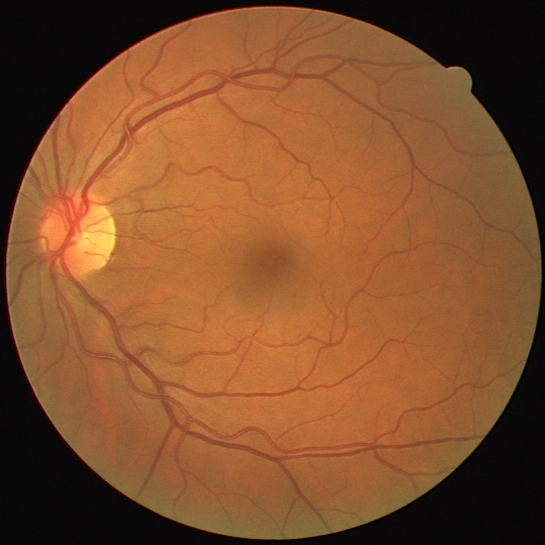

In [3]:
# download and load an example image, taken from the DRIVE dataset (unfortunately, I cannot show UK Biobank images here)
!wget https://github.com/SHI-Labs/SGL-Retinal-Vessel-Segmentation/raw/main/dataset/DRIVET/HR/01_training.tif?raw=true -O test_img_DRIVE.tif -q
from PIL import Image
img_original = Image.open('test_img_DRIVE.tif').crop((10, 25, 555, 570))
img = img_original
img_original

We cropped the image slightly to reduce the black borders. This is roughly what the UKB images DART was trained on looked like.

Let's see what it takes to compute the Fractal Dimension of this image with DART:

In [4]:
original_FD = model_pipeline(img)[0] # [0] selects the first and only element of the numpy array that the pipeline returns
print(f'DART predicts that VAMPIRE would compute a FD for this image of approx.: {original_FD:.4f}')

DART predicts that VAMPIRE would compute a FD for this image of approx.: 1.5268


That was pretty easy. But is it fast?

### Speed

With batched inference, we managed over 1,000 img/s on a single GPU (see the paper for more detail). This convenience pipeline will be a bit slower, but hopefully, you'll find it very easy to use! And, slower is not slow. Let's see how fast it is.

We benchmark this twice: Once with GPU if it is available, the second time with the CPU.

First, let's look at what GPU we have:

In [5]:
!nvidia-smi -L

GPU 0: Quadro RTX 6000 (UUID: GPU-34618e10-c6af-c05e-1546-97f5252e4796)


Then benchmark how long it takes to transform a single image:

In [6]:
%%timeit
model_pipeline(img)[0]

4.98 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Set pipeline to use CPU only

In [7]:
model_pipeline.update_device('cpu')

Benchmark with CPU:

In [8]:
%%timeit
model_pipeline(img)[0]

10.5 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


These times will depend very much on your device. On my GPU/CPU, I'm getting 5.0/10.5 ms per image, so roughly 200 imgs/s using the GPU  and 95 imgs/s using the CPU only. Bear in mind that non-batched inference is quite inefficient compared to batched. 

Still, on a 1 hour lunch break (60 min * 60 s/min = 3,600 s), you could process roughly 720,000 images on this GPU or 342,000 images on just this CPU. - So you'd come back from lunch, and have processed pretty much all of UK Biobank, and that's not even the most efficient way of doing things. Neat!

And if your machine is a fair bit slower than this one (😒), then it's probably still only an afternoon, over night, or at worst over the weekend. (😊)

So, it's fast, I would say. But is it robust?

### Robustness

More detailed results are in the paper. There, we used a few thousand, held-out UK Biobank images that other researchers had deemed to be in the top 60% in terms of quality and sufficient for computing fractal dimension with VAMPIRE. We then used random degradations with different levels of severity and showed that DART could recover the VAMPIRE FD computed on the original high quality image quite well.

Here, we will simply take the single example image and show how the DART FD estimate changes as we change brightness/contrast/gamma/blur separately. Note, we cover (in my opinion) pretty severe versions of these.

Unfortunately, we do not have the VAMPIRE FD value for the test images (and I cannot plot UKB images here). So, for reference we use the DART FD value on the high quality image. That will be shown as a red line for reference. In our paper, on the held-out, unseen test images, we that our DART FD correlated very strongly with the VAMPIRE FD on the original images (Pearson r=0.9572), so it should be a good reference value.

We will also show two fainter red lines, indicating the original DART FD +- 0.25 * IQR of VAMPIRE FD on the UK Biobank images. Let's break this down: IQR stands for interquartile range and is a robust equivalent of the standard deviation (both describe the scale of the data, but IQR is more appropriate as FD is longtailed). We show these lines as a sense of how much the DART FD estimated from the degraded images deviates from the original value, relative to how much FD tends to vary in the first place. Note, that we use +- 0.25 * IQR (a quarter of the interquartile range, what a mouthful), rather than +- 1 IQR. Thus, staying within these horizontal lines indicates very good robustness to the given level of degradation, in my opinion.

We first define a helper function for plotting:

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms import functional_pil as TF
from torchvision.transforms import functional as TF_generic
def plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, title='', iqr_range=0.25):
    n_imgs = len(facts)
    fig, ax = plt.subplots(2, n_imgs, figsize=(3*n_imgs*0.6, 7*0.6))
    _crop = (250, 80, 400, 230)
    for idx in range(len(facts)):
        ax[1, idx].imshow(imgs[idx])
        ax[1, idx].axis('off')
        ax[0, idx].imshow(imgs[idx].crop(_crop))
        ax[0, idx].axis('off')

        ax[0, idx].set_title(f'{facts[idx]:.1f}')
    plt.suptitle(title, fontsize=25)
    plt.tight_layout()
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(3*n_imgs, 3))
    plt.plot(facts, FDs, marker='o', linestyle='--')
    plt.xlim(facts[0]-0.025, facts[-1]+0.04)
    plt.axhline(original_FD, c='red', lw=1.5)
    IQR_of_VAMPIRE_FD = -0.0409999999999997
    IQR_of_VAMPIRE_FD *= iqr_range
    plt.axhline(original_FD + IQR_of_VAMPIRE_FD, c='red', lw=1.5, alpha=0.5)
    plt.axhline(original_FD - IQR_of_VAMPIRE_FD, c='red', lw=1.5, alpha=0.5)
    plt.grid(True)
    plt.show()

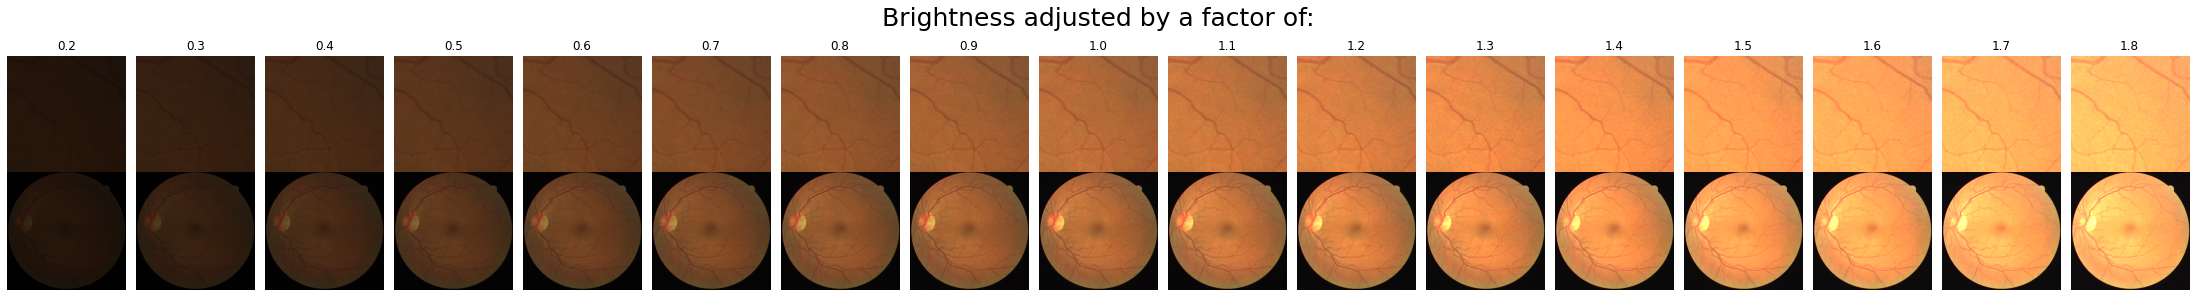

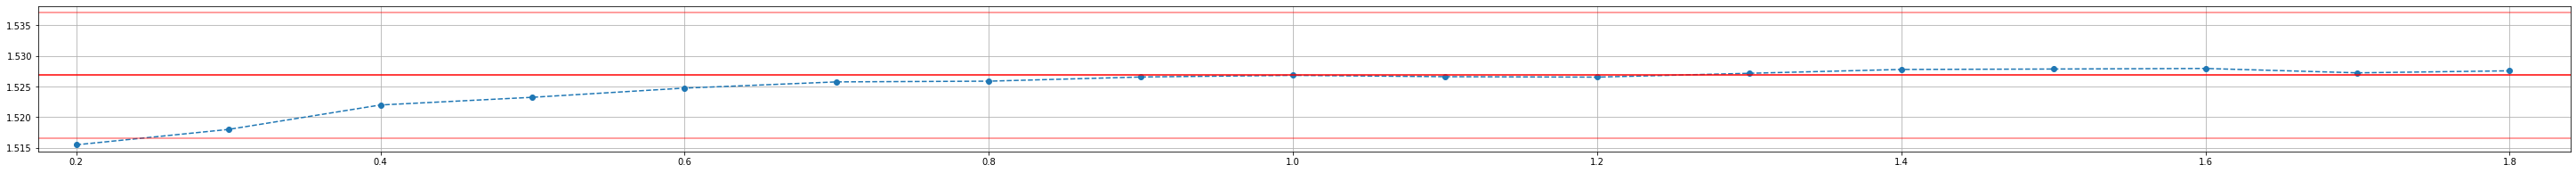

Min FD: 1.5155	Max FD: 1.5280	Original FD: 1.5268


In [10]:
facts = np.arange(0.2, 1.81, step=0.1)
imgs = [TF.adjust_brightness(img_original, brightness_factor=_fact) for _fact in facts]
FDs = [model_pipeline(img)[0] for img in imgs]
plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, 'Brightness adjusted by a factor of:')
print(f'Min FD: {np.min(FDs):.4f}\tMax FD: {np.max(FDs):.4f}\tOriginal FD: {original_FD:.4f}')

Brief reminder: The images on top correspond to the DART FD values on the plot as the bottom. The horizontal line in bold red is the DART FD value for the original image. The two fainter horizontal red lines are +- 0.25 IQR of VAMPIRE FD on UK Biobank, to convey a sense of scale. Finally, the images on top show both a zoomed in patch and the whole image, to give you a good picture of how badly degraded the image is in general and when looking at the finer vessels.

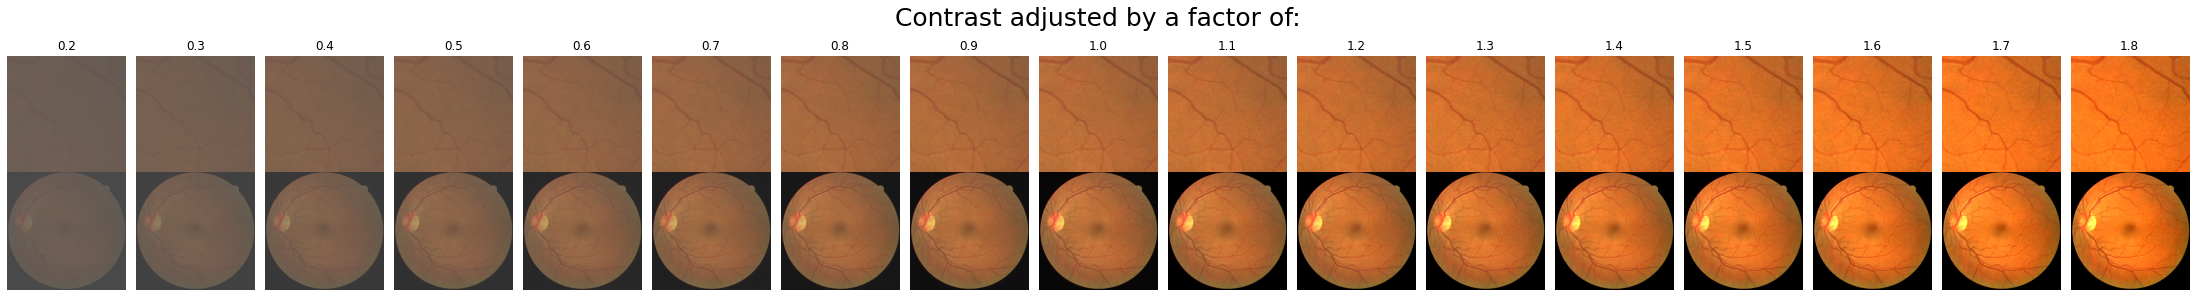

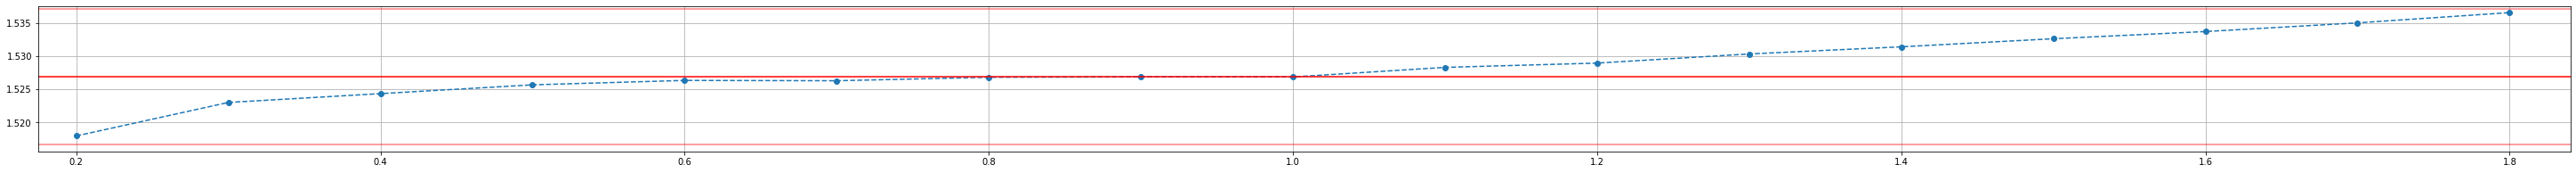

Min FD: 1.5179	Max FD: 1.5366	Original FD: 1.5268


In [11]:
facts = np.arange(0.2, 1.81, step=0.1)
imgs = [TF.adjust_contrast(img_original, contrast_factor=_fact) for _fact in facts]
FDs = [model_pipeline(img)[0] for img in imgs]
plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, 'Contrast adjusted by a factor of:')
print(f'Min FD: {np.min(FDs):.4f}\tMax FD: {np.max(FDs):.4f}\tOriginal FD: {original_FD:.4f}')

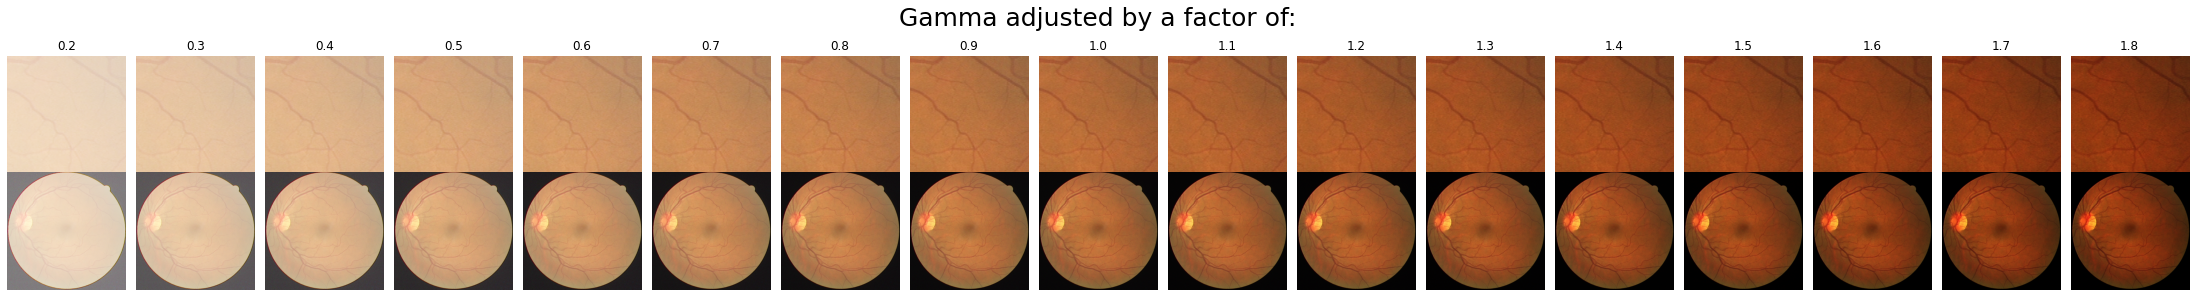

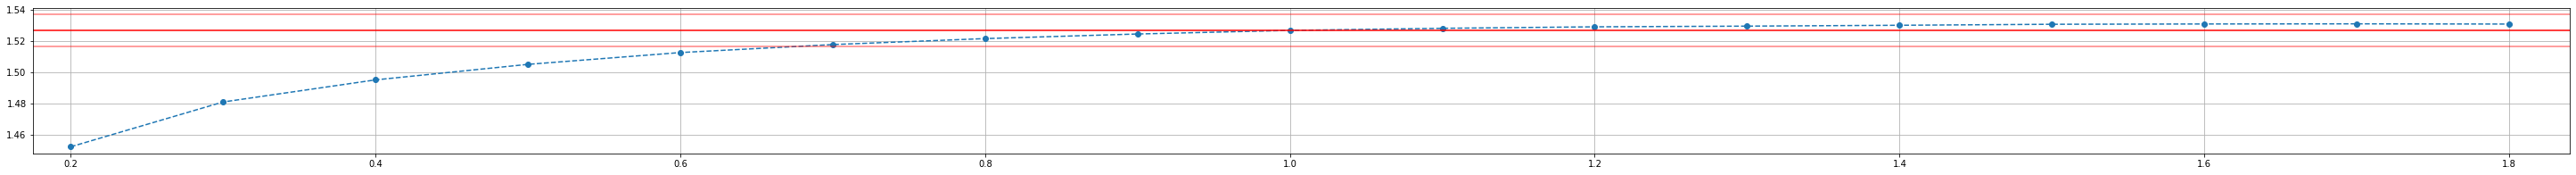

Min FD: 1.4522	Max FD: 1.5310	Original FD: 1.5268


In [12]:
facts = np.arange(0.2, 1.81, step=0.1)
imgs = [TF.adjust_gamma(img_original, gamma=_fact) for _fact in facts]
FDs = [model_pipeline(img)[0] for img in imgs]
plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, 'Gamma adjusted by a factor of:')
print(f'Min FD: {np.min(FDs):.4f}\tMax FD: {np.max(FDs):.4f}\tOriginal FD: {original_FD:.4f}')

Even for quite extreme brightness and contrast changes, the DART FD changes by at most slightly over 0.25 * IQR of VAMPIRE FD, but usually much less.

For very low values of gamma, the performance drops quite a bit. For values lower than 0.5, performance is not very good. But looking at the images, that makes sense as we lose the small vessels almost entirely. (- This might look similar but it's quite different from high brightness where DART does very well). For gamma values above 0.7, DART does quite well again, even at very high values. And bear in mind that we're plotting only 1/4 of the IQR.

But how about blurry images? We'll try Gaussian blur, varying either the kernel size, or sigma.

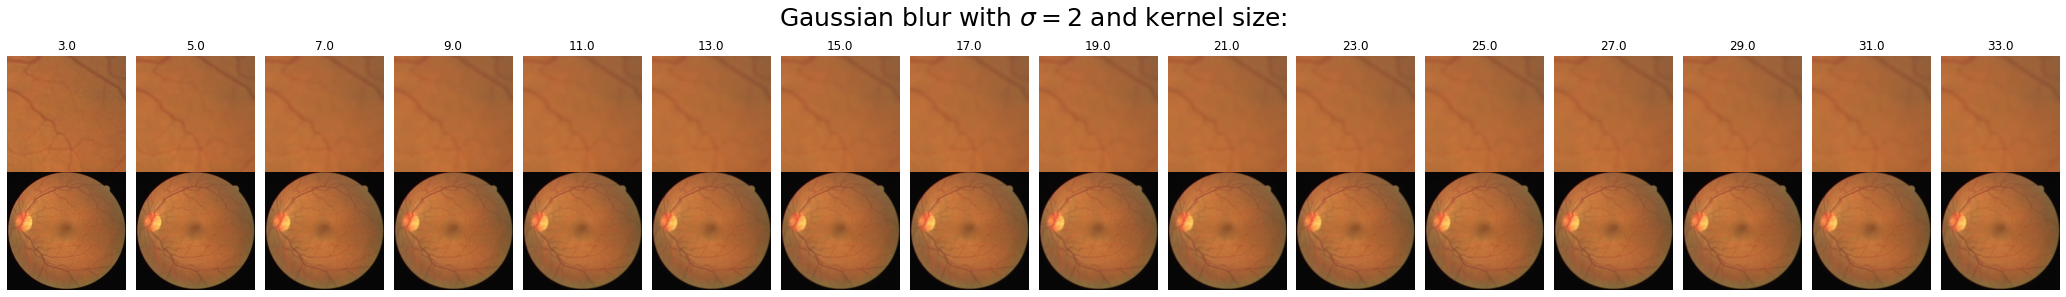

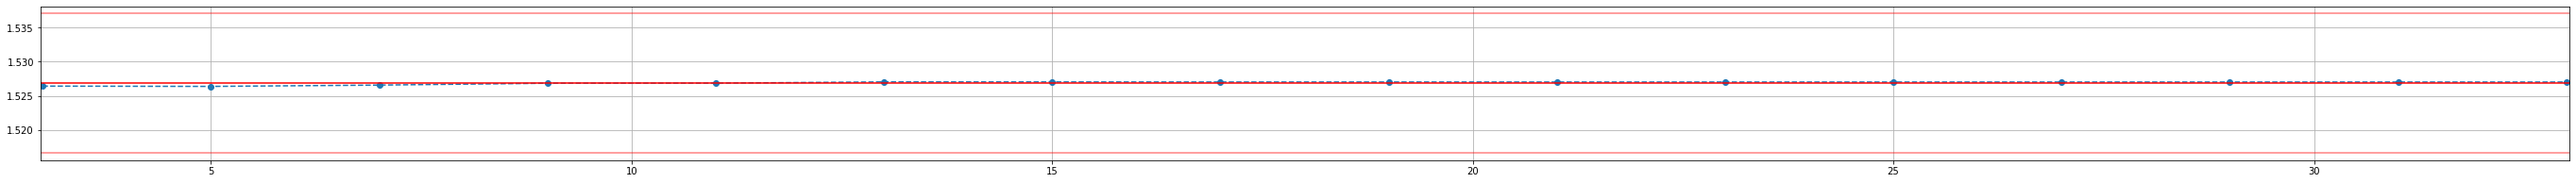

Min FD: 1.5264	Max FD: 1.5270	Original FD: 1.5268


In [13]:
facts = list(range(3,35,2))
imgs = [TF_generic.gaussian_blur(img_original, sigma=2, kernel_size=_fact) for _fact in facts]
FDs = [model_pipeline(img)[0] for img in imgs]
plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, 'Gaussian blur with $\\sigma=2$ and kernel size:')
print(f'Min FD: {np.min(FDs):.4f}\tMax FD: {np.max(FDs):.4f}\tOriginal FD: {original_FD:.4f}')

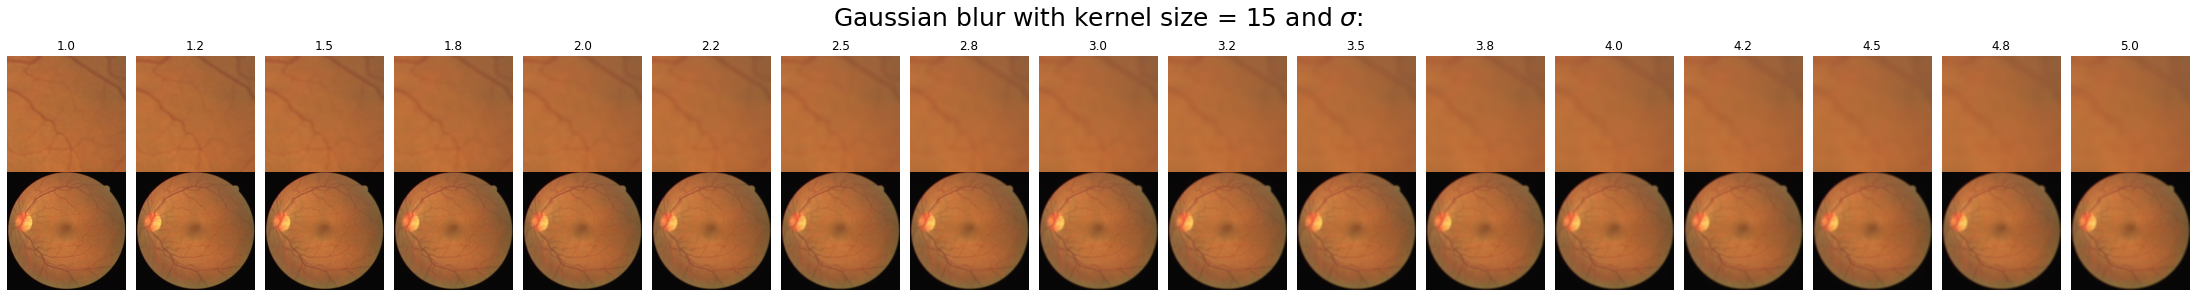

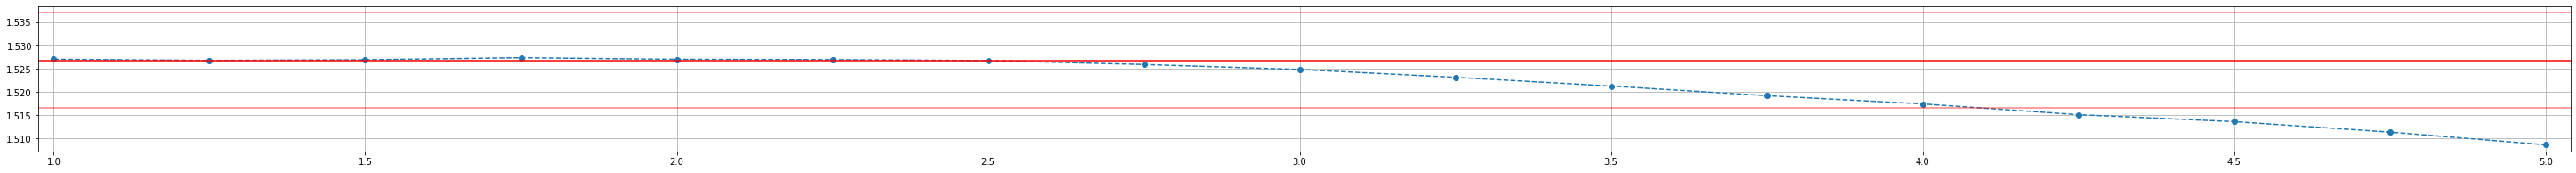

Min FD: 1.5086	Max FD: 1.5274	Original FD: 1.5268


In [14]:
facts = np.arange(1, 5.01, 0.25)
imgs = [TF_generic.gaussian_blur(img_original, sigma=_fact, kernel_size=15) for _fact in facts]
FDs = [model_pipeline(img)[0] for img in imgs]
plot_degraded_imgs_plus_DART_fd(imgs, facts, FDs, 'Gaussian blur with kernel size = 15 and $\\sigma$:')
print(f'Min FD: {np.min(FDs):.4f}\tMax FD: {np.max(FDs):.4f}\tOriginal FD: {original_FD:.4f}')

For these blurry images, DART again does quite well, unless we use very high sigma values with a relatively large kernel (bear in mind the image is about 550x550). Still, in the above plot, we can make out the vessels quite well on the left-most image, which is already slightly blurred. Once sigma goes to about 2.5, it's already hard to see the smaller vessels, but our model still does very well. Only once sigma goes beyond 4.0 does the DART estimate go outside +- 0.25 * IQR of its original value. However, at that point, the images are very severely degraded. To be honest, I'm actually somewhat surprised that it's possible to recover a decent FD estimate at that blur level.

As blur can be hard to see on the smaller plots, so for reference here's the images at sigmas 2, 3, 4, 5 in higher resolution:

Original Image


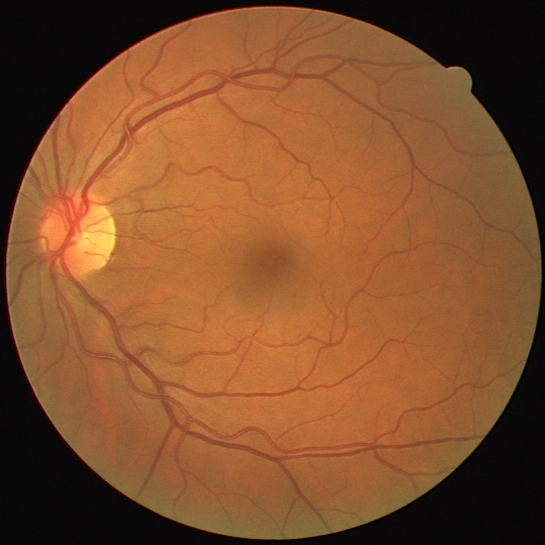

In [15]:
print(f'Original Image')
display(img_original)

Image blurred with kernel size = 15 and $\sigma$=2


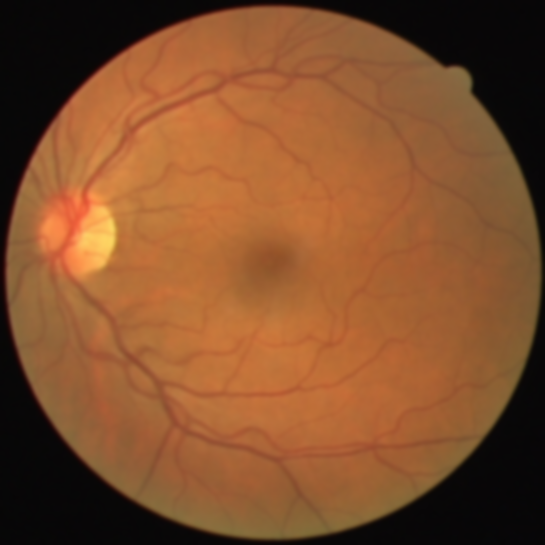

In [16]:
print(f'Image blurred with kernel size = 15 and $\\sigma$=2')
display(imgs[(facts==2.).argmax()])

Image blurred with kernel size = 15 and $\sigma$=3


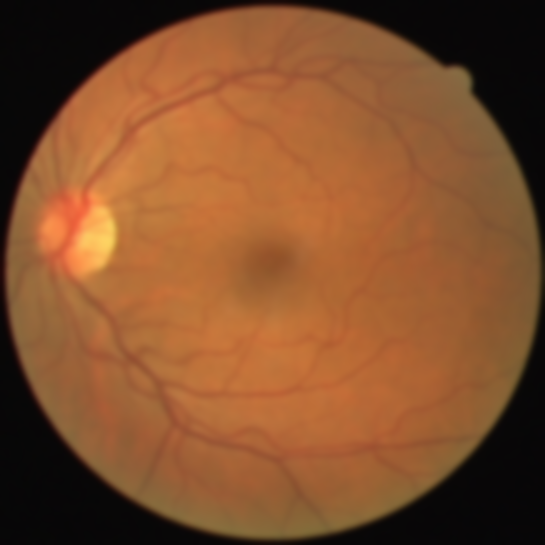

In [17]:
print(f'Image blurred with kernel size = 15 and $\\sigma$=3')
display(imgs[(facts==3.).argmax()])

Image blurred with kernel size = 15 and $\sigma$=4


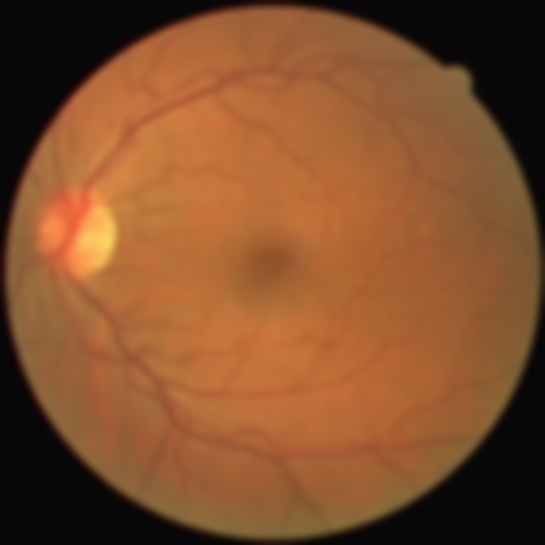

In [18]:
print(f'Image blurred with kernel size = 15 and $\\sigma$=4')
display(imgs[(facts==4.).argmax()])

Image blurred with kernel size = 15 and $\sigma$=5


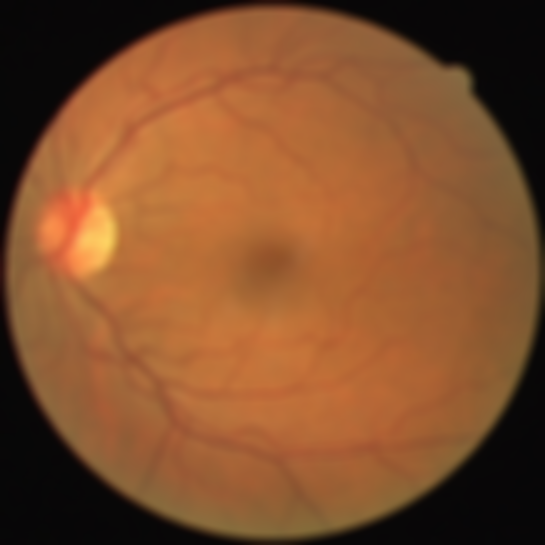

In [19]:
print(f'Image blurred with kernel size = 15 and $\\sigma$=5')
display(imgs[(facts==5.).argmax()])

At sigma=4, DART still does well, but to me it already looks like a useless, blurry mess. Pretty cool that this is possible.

I could barely see the difference between sigma=4 and sigma=5, so to double check, I've plotted an image with just the differences between the two:

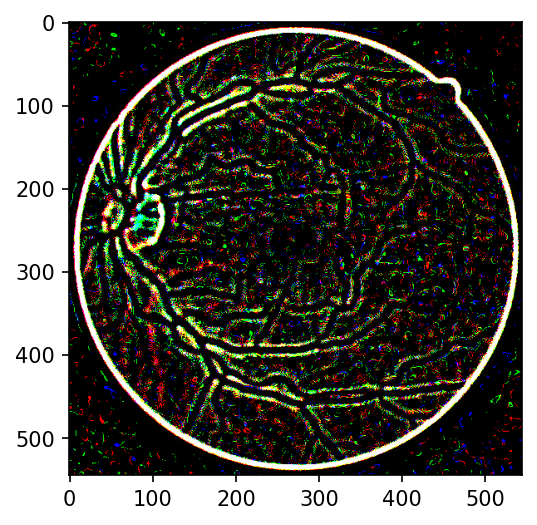

In [25]:
diff_4_5 = np.array(imgs[(facts==5.).argmax()]) - np.array(imgs[(facts==4.).argmax()])
plt.figure(dpi=150)
plt.imshow(diff_4_5)
plt.show()

This looks quite pretty, and shows that they are indeed different. Apparently, those small differences do make a difference to our model.

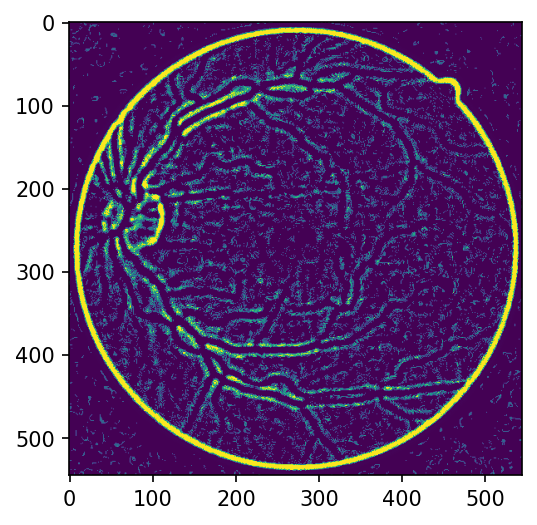

In [27]:
plt.figure(dpi=150)
plt.imshow(diff_4_5.sum(axis=2))
plt.show()

### Conclusion

If you made it this far: Cool! I (in my biased opinion) think that these results are very encouraging and hope to continue this work in a number of ways.

However, let me know what you think. Especially, if you disagree with my optimism (which I am sure you have very good reasons for that I simply didn't think of), it be very useful to hear your concerns. Thanks.